### 📘 **Holdout Evaluation Script: MLP Model**
This script performs **inference and evaluation** of a trained MLP model on the **holdout dataset**.

It includes:
- 🔧 Loading model configuration and weights  
- 🧠 Reconstructing the model architecture  
- 🔮 Predicting wind pressure on the holdout set  
- 📊 Calculating key metrics: **R²**, **MAE**, **MSE**  
- 🖼 Visualizing: `True vs Predicted`, `Residuals Histogram`  
- 💾 Saving metrics (`.json`) and plots (`.png`) to the model's directory  

**Inputs:**
- `config_*.json`: configuration file with hyperparameters  
- `best_model_weights_*.pt`: model weights  
- `WindLoading_HoldOut.csv`: holdout dataset  

**Outputs:**
- `holdout_eval_*.json`: performance metrics  
- `holdout_plot_*.png`: result plots  

In [3]:
# 📦 Стандартные библиотеки
import json
from pathlib import Path

# 🧪 Научные библиотеки
import numpy as np
import pandas as pd

# 🔢 PyTorch
import torch
import torch.nn as nn

# 📊 Метрики и визуализация
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


✅ Model configuration loaded successfully.
🔧 Activation: Tanh, Hidden units: 128
✅ Model weights loaded successfully.
📈 Holdout evaluation:
   R²   = 0.8470
   MAE  = 0.0241
   MSE  = 0.001076
📁 Metrics saved to: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/mlp_128h_6e-03lr_best/holdout_eval_128h_6e-03lr_ex.json


/tmp/ipykernel_10072/1248955623.py:138: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10072/1248955623.py:138: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


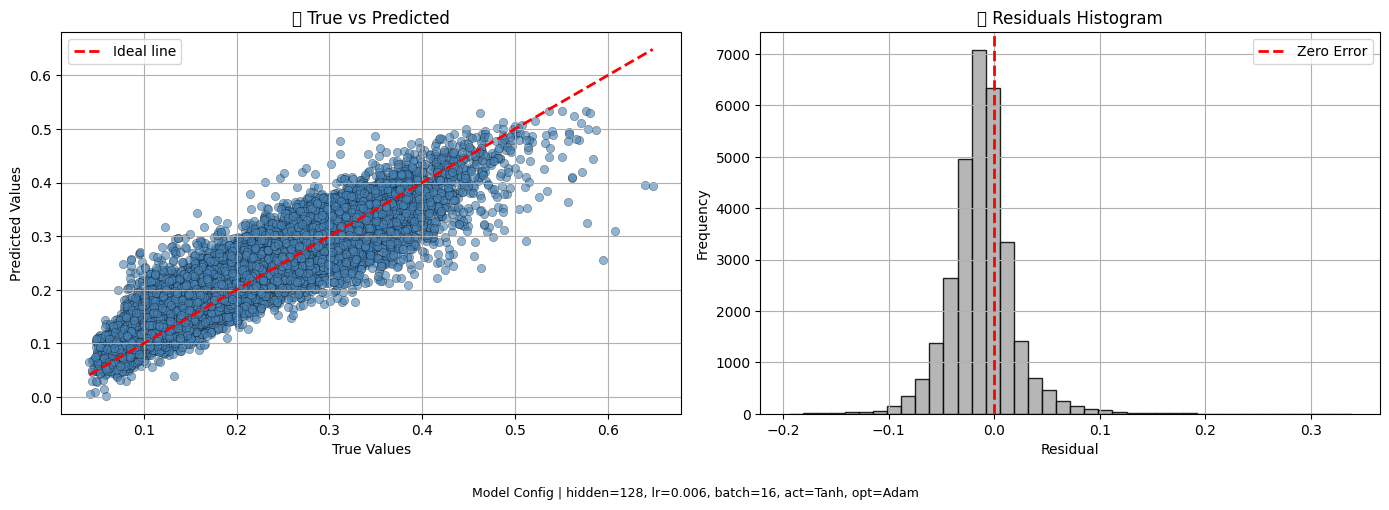

/tmp/ipykernel_10072/1248955623.py:146: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_10072/1248955623.py:146: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_path, dpi=300, bbox_inches='tight')


📁 Plots saved to: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/mlp_128h_6e-03lr_best/holdout_plot_128h_6e-03lr_ex.png


In [4]:
BASE_DIR = Path("/mnt/d/projects/wind_fluctuation_prediction_2025/final_models/mlp_128h_6e-03lr_best")
HOLDOUT_PATH = Path("/mnt/d/projects/wind_fluctuation_prediction_2025/data/holdout/WindLoading_HoldOut.csv")
OUTPUT_DIR = Path("/mnt/d/projects/wind_fluctuation_prediction_2025/final_models/mlp_128h_6e-03lr_best")

config_path = next(BASE_DIR.glob("config*.json"))
config_filename = config_path.stem
suffix = config_filename.replace("config_mlp_", "")
weights_path = next(BASE_DIR.glob("best_model_weights*.pt"))
# metrics_path = BASE_DIR / f"holdout_eval_{suffix}.json"
metrics_path = OUTPUT_DIR / f"holdout_eval_{suffix}.json"



df = pd.read_csv(HOLDOUT_PATH)
X_holdout = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']].values
y_true = df['StdDev'].values

X_tensor = torch.tensor(X_holdout, dtype=torch.float32)
y_tensor = torch.tensor(y_true, dtype=torch.float32).view(-1, 1)


# 🧠 Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# 📄 Load model configuration
with open(config_path, "r") as f:
    config = json.load(f)

# 🔧 Map activation function name to PyTorch class
activation_map = {
    "ReLU": nn.ReLU,
    "Tanh": nn.Tanh,
    "Sigmoid": nn.Sigmoid,
    "LeakyReLU": nn.LeakyReLU
}

# 🧠 Select activation function
activation_fn_class = activation_map.get(config["activation_fn"], nn.ReLU)  

# 🧠 Build the model
model = MLP(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    activation_fn=activation_fn_class
)

# 💾 Load model weights
# model.load_state_dict(torch.load(weights_path))
model.load_state_dict(torch.load(weights_path, map_location=torch.device("cpu")))

model.eval()
print("✅ Model configuration loaded successfully.")
print(f"🔧 Activation: {config['activation_fn']}, Hidden units: {config['hidden_dim']}")
print("✅ Model weights loaded successfully.")

# 🔮 Make predictions on holdout set
with torch.no_grad():
    y_pred = model(X_tensor).numpy()

# 📊 Evaluate metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print("📈 Holdout evaluation:")
print(f"   R²   = {r2:.4f}")
print(f"   MAE  = {mae:.4f}")
print(f"   MSE  = {mse:.6f}")

# 💾 Save metrics to JSON
with open(metrics_path, "w") as f:
    json.dump({
        "R2": round(r2, 4),
        "MAE": round(mae, 4),
        "MSE": round(mse, 6)
    }, f, indent=4)

print(f"📁 Metrics saved to: {metrics_path}")

# 🧾 Hyperparameters for plot title
label_info = (
    f"hidden: {config['hidden_dim']}, "
    f"lr: {config['lr']}, "
    f"act: {config['activation_fn']}, "
    f"opt: {config['optimizer_name']}, "
    f"batch: {config['batch_size']}, "
)


# 📉 Residuals
residuals = y_true - y_pred.flatten()

# 📊 Side-by-side plots with better style
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 🎯 True vs Predicted
axes[0].scatter(y_true, y_pred, alpha=0.6, color="steelblue", edgecolors='k', linewidths=0.3)
axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label="Ideal line")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
axes[0].set_title("🎯 True vs Predicted", fontsize=12)
axes[0].grid(True)
axes[0].legend()

# 📊 Residuals Histogram
axes[1].hist(residuals, bins=40, alpha=0.85, color='darkgray', edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', lw=2, label="Zero Error")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Frequency")
axes[1].set_title("📊 Residuals Histogram", fontsize=12)
axes[1].grid(True)
axes[1].legend()

# 📝 Shared caption with model config
# вместо suptitle
fig.text(
    0.5, -0.05,
    f"Model Config | hidden={config['hidden_dim']}, "
    f"lr={config['lr']}, batch={config['batch_size']}, "
    f"act={config['activation_fn']}, opt={config['optimizer_name']}",
    ha='center',
    fontsize=9
)

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Leave space for title

plt.show() 

# 💾 Save plot to file
# plot_path = BASE_DIR / f"holdout_plot_{suffix}.png"
plot_path = OUTPUT_DIR / f"holdout_plot_{suffix}.png"
fig.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"📁 Plots saved to: {plot_path}")

